In [1]:
!pip install tslearn

In [ ]:
import pandas as pd
import numpy as np
import time
# from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# from utils import *
from db import db

In [ ]:
season_df = db.get_table('ir_db', 'preds_season_by_category')

In [ ]:
season_df.date = pd.to_datetime(season_df.date)

In [ ]:
season_df['dayofweek'] = season_df.date.dt.dayofweek
season_df['year'] = season_df.date.dt.year


In [ ]:
seasons_pivot = pd.pivot_table(
    data=season_df[(season_df['dayofweek'] == 0) & (season_df['year'].isin([2023,2024,2025]))], 
    columns='category', index='date', values='season',aggfunc='sum').dropna()

In [ ]:
seasons_pivot.shape

In [ ]:
seasons_scaled = seasons_pivot.copy()
for category in seasons_pivot.columns:
    scaler = StandardScaler()
    seasons_scaled[category] = scaler.fit_transform(seasons_scaled[category].values.reshape(-1, 1))

In [ ]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(seasons_scaled.T)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(seasons_scaled.T, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [141]:
n_clusters = 7
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10,random_state=42)
ts_kmeans.fit(seasons_scaled.T)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=7, n_jobs=6,
                 random_state=42)

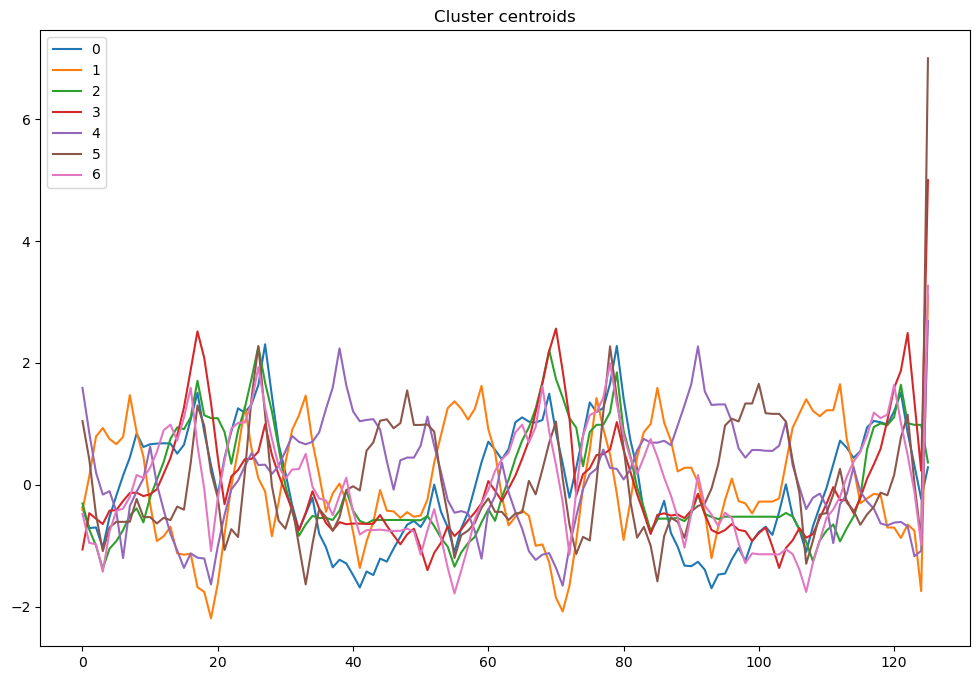

In [142]:
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [165]:
seasons_scaled.loc['cluster'] = ts_kmeans.predict(seasons_scaled.T)

/Users/FainaAlimbaeva/anaconda3/lib/python3.10/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 338 1-dimensional timeseries
  warnings.warn(


In [166]:

pd.DataFrame(seasons_scaled.T['cluster'].value_counts())

,cluster
3.0,76
6.0,58
0.0,57
4.0,54
2.0,46
5.0,26
1.0,21


In [167]:
seasons_scaled_T = seasons_scaled.T

In [168]:
category_clusters = seasons_scaled.loc['cluster'].reset_index()

In [170]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        # ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(seasons_scaled_T[seasons_scaled_T.cluster==cluster])